# Clasificación No Balanceada en Inversiones Startups (Crunchbase)

Este trabajo aborda un problema de **clasificación binaria no balanceada** a partir de un dataset abierto de inversiones en startups, disponible en [Kaggle - Startup Investments Crunchbase](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

## Descripción del Proyecto

Este proyecto se desarrolla para la asignatura de **Minería de Datos**, como parte del trabajo final grupal. El objetivo es aplicar técnicas de análisis y modelado sobre un conjunto de datos reales para abordar un problema de clasificación desequilibrada.

A partir del dataset original, se ha redefinido el problema como una clasificación binaria no balanceada. Por ejemplo, se puede predecir si una startup ha recibido financiación por encima de un determinado umbral, o si pertenece a un grupo de industrias consideradas “de alto crecimiento”.

## Objetivos

1. **Formulación del problema** como tarea de clasificación binaria no balanceada.
2. **Análisis exploratorio** de las variables del dataset.
3. **Preparación de los datos**, incluyendo tratamiento de valores perdidos, normalización, codificación y detección de outliers.
4. Aplicación de **técnicas de aprendizaje supervisado**:
   - **K-Nearest Neighbors (KNN)**
   - **Árboles de Decisión**
5. Evaluación mediante **métricas adecuadas** para clasificación no balanceada (como *F1-Score*, *balanced accuracy*, *AUC*, etc.) y **validación cruzada**.
6. Uso de **pipelines y transformadores** para automatizar el preprocesamiento.
7. Aplicación de técnicas de **muestreo (undersampling/oversampling)** y **ajuste de umbrales**.
8. Estudio de la **interpretabilidad del modelo final**.

## Estructura del Notebook

Este notebook está estructurado en las siguientes secciones:

- [1. Carga y descripción del dataset](#)
- [2. Análisis exploratorio de los datos (EDA)](#)
- [3. Formulación del problema de clasificación binaria no balanceada](#)
- [4. Preprocesamiento de datos](#)
- [5. Construcción del pipeline con KNN](#)
- [6. Evaluación del modelo y análisis de resultados](#)
- [7. Árboles de decisión y comparación](#)
- [8. Interpretabilidad del modelo final](#)
- [9. Conclusiones](#)

## 1. Elección del problema

El problema elegido se basa en el dataset **Startup Investments - Crunchbase**, disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo es construir un modelo de **clasificación binaria no balanceada** que permita **predecir si una startup será adquirida** o no. Para ello, hemos definido la variable objetivo `target` de la siguiente forma:

- `target = 1` si la columna `status` es `"acquired"`
- `target = 0` en cualquier otro caso (por ejemplo: `closed`, `ipo`, `operating`, etc.)

Este planteamiento genera un claro desbalance entre clases, ya que el número de startups adquiridas es mucho menor que el resto.

Comenzamos leyendo el dataset original sobre inversiones en startups, proporcionado por Crunchbase y disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo en esta fase inicial es familiarizarnos con la estructura de los datos: número de ejemplos, variables disponibles, tipos de datos y primeras observaciones. Esto nos permitirá definir correctamente el problema de clasificación binaria no balanceada.

El archivo utilizado se llama `investments_VC.csv` y se encuentra en la carpeta `data/`.

In [2]:
import pandas as pd

ruta_datos = "data/investments_VC.csv"

df = pd.read_csv(ruta_datos, encoding="latin1")

print("Dimensiones del dataset: ", df.shape)
df.head()

Dimensiones del dataset:  (54294, 39)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Métrica de rendimiento y validación

Dado que se trata de un problema de **clasificación no balanceada**, y el enfoque del proyecto es el de una entidad inversora interesada en identificar startups que realmente serán adquiridas, la métrica principal que se optimizará será la **precisión**.

Esta métrica permite minimizar el número de **falsos positivos**, es decir, evitar etiquetar como "adquirida" una startup que realmente no lo será, lo cual es crucial desde una perspectiva de inversión.

También se calcularán otras métricas de forma complementaria:

- **Fβ-score**: como nos explicó en clase de prácticas, permite ajustar la importancia del *recall* frente a la *precisión*, según lo que queramos priorizar.
- **F1-score**: útil para comparar modelos cuando buscamos un equilibrio entre precisión y recall.
- **AUC - Precision Recall**: evalúa qué tan bien se separan las clases, especialmente en problemas desbalanceados.
- **Balanced Accuracy**: nos ayuda a medir el rendimiento general sin que una clase pese más que otra.



### Validación

Usaremos StratifiedKFold porque así nos aseguramos de que cada partición de nuestro conjunto de datos mantenga la misma proporción de clases que el conjunto original. Esto es muy importante en nuestro caso, ya que tenemos un problema de clasificación en el que las clases están desbalanceadas. Al asegurarnos de que cada fold represente la distribución de clases, evitamos sesgos en la evaluación del rendimiento y obtenemos mejores estimaciones. Además, nos ayuda a usar mejor nuestros datos y a entrenar modelos que aprendan de forma más equilibrada y realista según cómo es de verdad el problema.


## 3. Análisis de las variables de entrada

El dataset contiene información sobre startups, incluyendo el país, la categoría, la cantidad de inversión recibida, el número de rondas de financiación, y fechas clave como fundación y adquisiciones.

Variables candidatas para el modelo:

- `country_code`
- `category_code`
- `funding_total_usd`
- `funding_rounds`
- `founded_at`
- `first_funding_at`
- `last_funding_at`

Se han detectado:
- Variables numéricas con escalas muy diferentes
- Fechas con valores ausentes o mal formateados
- Variables categóricas con muchos valores únicos
- Campos de texto que se ignorarán o transformarán

El análisis preliminar sugiere que las startups con más financiación y más rondas de inversión tienen mayor probabilidad de ser adquiridas.


Lo primero que hacemos es renombrar la variable a predecir. Se llama `status` y le llamamos `exito`.

In [4]:
df.rename(columns = {'status':'exito'}, inplace = True)
df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,exito,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora visualizamos la descripción de nuestro dataset con `describe` de la libría `pandas`

In [10]:
df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,38482.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,...,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,2007.359129,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,1.628453e+05,...,3.845592e+04,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,7.579203,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,5.612088e+06,...,3.864461e+06,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,...,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


Podemos observar que las empresas de nuestros datos se fundaron entre 1902 y 2014

In [9]:
def year_group(row):
    if row['founded_year'] >= 1900 and row['founded_year'] <= 1925:
        row['founded_year_group'] = 'less_than_1925'
    elif row['founded_year'] > 1925 and row['founded_year'] <= 1950:
        row['founded_year_group'] = '1925_1950'
    elif row['founded_year'] > 1950 and row['founded_year'] <= 1975:
        row['founded_year_group'] = '1950_1975'
    elif row['founded_year'] > 1975 and row['founded_year'] <= 2000:
        row['founded_year_group'] = '1975_2000'
    elif row['founded_year'] > 2000:
        row['founded_year_group'] = '2000_2014'
    else:
        row['founded_year_group'] = ''
    return row['founded_year_group']

df['founded_year_group'] =  df.apply(year_group,axis =1)

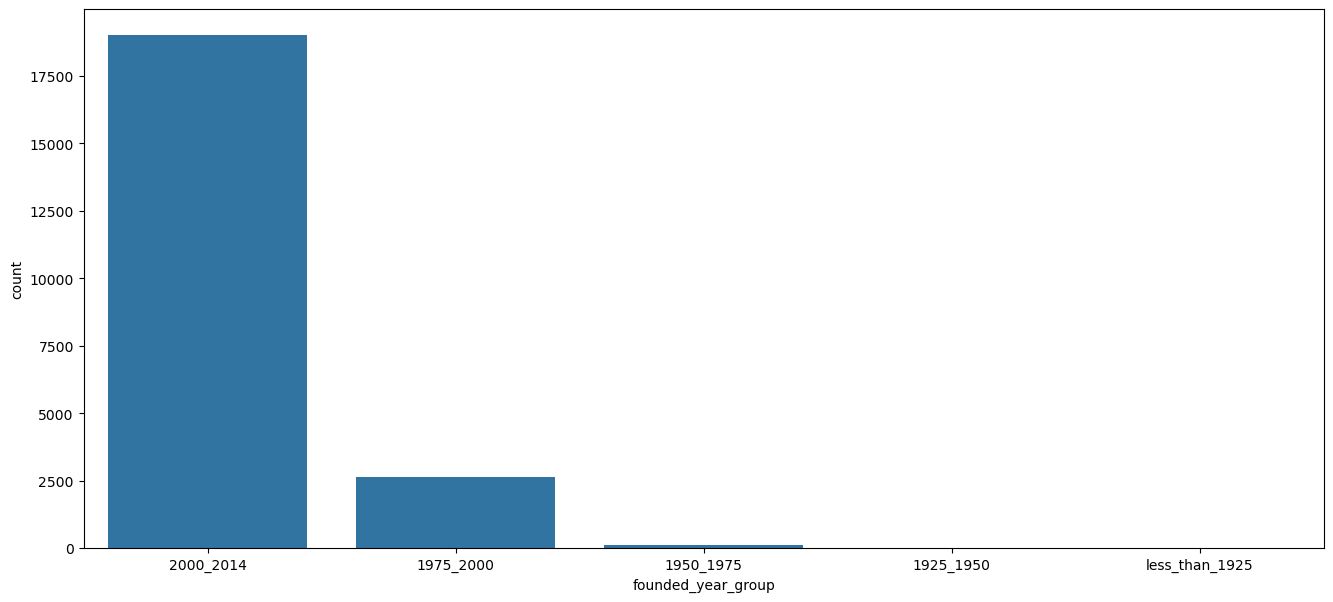

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,7))
sns.countplot(x = 'founded_year_group', data = df.dropna())
plt.show()

Se puede observar que casi todas las empresas se fundan entre el año `2000` y `2014`. Por ello, ahora ploteamos la gráfica de solo los años `2000` a `2014`.

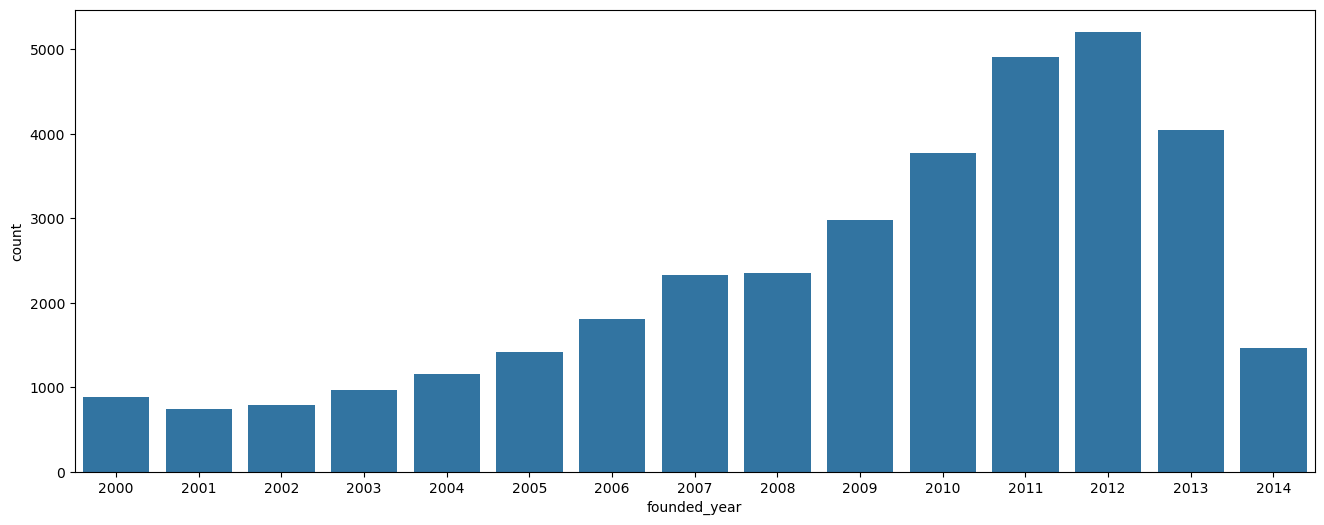

In [33]:
df_new = df[df['founded_year'] >= 2000].copy()
df_new['founded_year'] = df_new['founded_year'].astype(int)
plt.figure(figsize = (16,6))
sns.countplot(x = 'founded_year', data = df_new)
plt.show()

Se puede observar que el número de startups **aumenta** cada año.

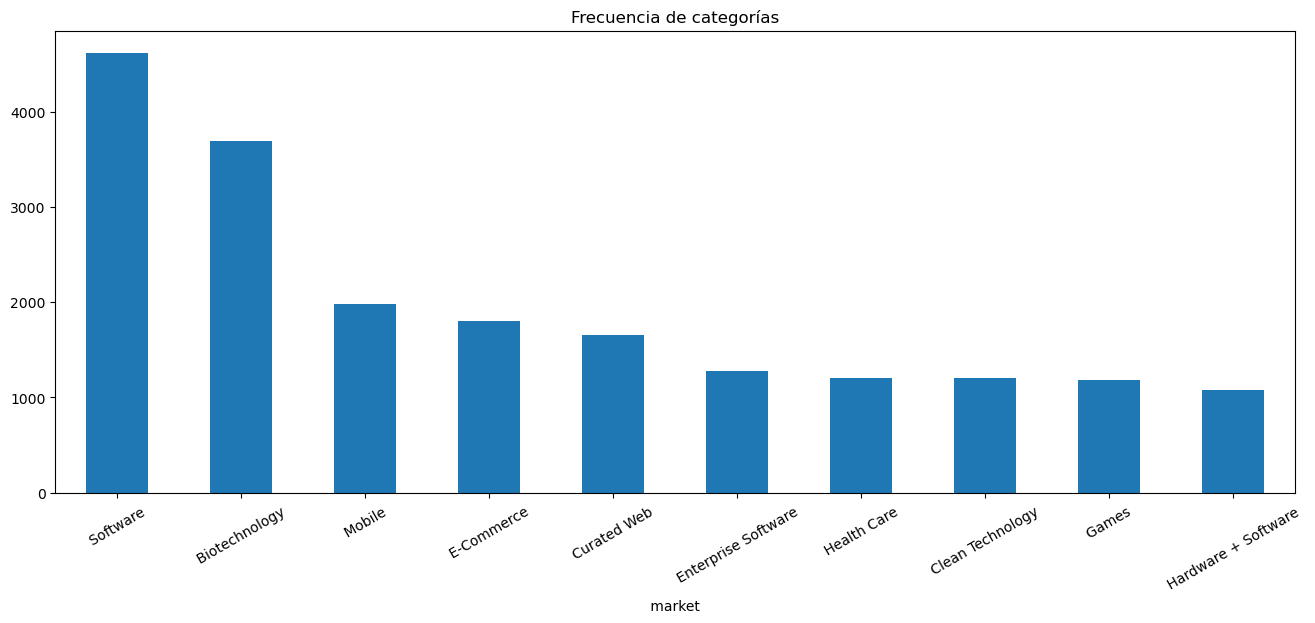

In [37]:
df[' market '].value_counts().head(10).plot(kind='bar', figsize=(16, 6))
plt.title('Frecuencia de categorías')
plt.xticks(rotation=30)
plt.show()

Podemos observar que casi todas las startups son de `Software` y `Biotechnology`, seguidas de `Mobile`,`E-Commerce` y `Curated Webs`.